In [1]:
from argparse import Namespace
from classifier import *

from dataset import *
from vectorizer import *

import torch


/home/nikos/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def use_cuda():
    return torch.device("cpu" if torch.cuda.is_available() else "cpu")

args = Namespace (
    in_features=None,
    out_units=3,
    units_per_layer=[128, 64],
    dataset=None,
    optimizer="Adam",
    criterion="bce_ls",
    save_dir='../trained_models/bow.pth',
    batch_size=128,
    learning_rate=0.001,
    num_epochs=10,
    device=use_cuda(),
    binary_class=False,
    embed_dim=300,
    freeze_embedding=False,
    filter_sizes=[3, 4, 5],
    num_filters=[100, 100, 100],
    pretrained_embedding=None
)

In [3]:
args.dataset = TextDataset.load_dataset_and_make_vectorizer("../data/Tweets.csv")
args.in_features = len(args.dataset.get_vectorizer().text_vocab)
args.out_features = len(args.dataset.get_vectorizer().label_vocab)

[nltk_data] Downloading package stopwords to /home/nikos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
bow = BOWClassifier(args=args)
bow.setup()
bow.fit()

100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


In [5]:
loss, acc, f1 = bow.eval_net(mode='test')
print(loss)
print(acc)
print(f1)

0.5982280265201223
75.42613636363637
68.80553010514637


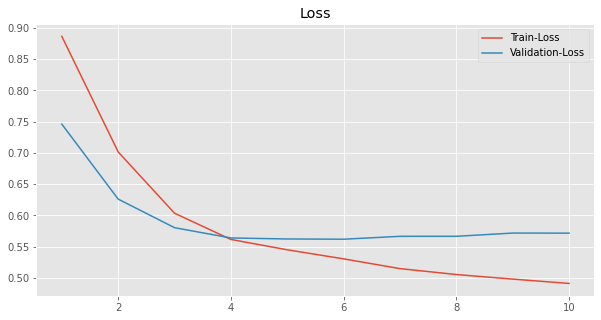

In [6]:
bow.plot_logs(title="Loss", legend=["Train-Loss", "Validation-Loss"])

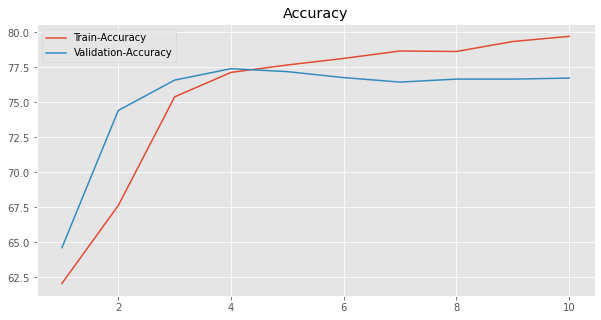

In [7]:
bow.plot_logs(title="Accuracy", legend=["Train-Accuracy", "Validation-Accuracy"])

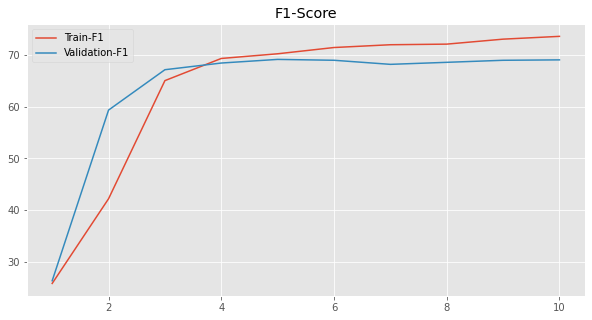

In [8]:
bow.plot_logs(title="F1-Score", legend=["Train-F1", "Validation-F1"])

In [9]:
args.dataset = TextDataset.load_dataset_and_make_vectorizer("../data/Tweets.csv", vectorizer_mode="padded")
args.in_features = len(args.dataset.get_vectorizer().text_vocab)
args.out_features = len(args.dataset.get_vectorizer().label_vocab)
args.pretrained_embedding = args.dataset.get_vectorizer().load_pretrained_embed("../data/crawl-300d-2M.vec")

[nltk_data] Downloading package stopwords to /home/nikos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
1999995it [00:24, 82522.45it/s]


In [10]:
cnn = CNNClassifier(args=args)
cnn.setup()
cnn.fit()

100%|██████████| 10/10 [04:05<00:00, 24.58s/it]


In [11]:
loss, acc, f1 = cnn.eval_net(mode='test')
print(loss)
print(acc)
print(f1)

0.6906796002929863
75.24857954545455
68.47504008781118
